## ToDo List
- [x] Checar se formato de datas conferem.
- [x] Remover UGs sem liberação OC
- [x] Considerar coluna montagem. Onde estiver vazio, pegar valor de Torres para EOL, no skate.
- [x] Calcular tempos de construção por marco: (IO_realizado - realizado), (CC_realizado - realizado) ...etc  (ordem:IO,CC,ME,OT)
- [x] Calcular atraso da operação comercial (realizado - outorgado)
- [x] Calcular média e std do tempo de construção.
- [x] Calcular data dos marcos medios (outorgado - tempo_medio_de_construcao) por fonte.
- [x] Calcular atrasos com base nos marcos medios
- [x] Calcular media e std dos atrasos. 
- [x] Normalizar os atrasos calculados (atraso - atraso_medio)/std
- [x] Construir matriz de correlação de Pearson
- [x] Calcular os coeficientes para regressão linear
- [x] Para UHE pegar todas UGs, para as demais pegar a primeira UG apenas
- [ ] Separar um cojunto aleatório para teste
- [x] Comparar pegando primeira UG e media por grupo
- [x] Separar curvas para ACR e ACL


## Resumo do script
- Carrega arquivo com ambos BDs => bd_combined
- Muda-se o ID das UHEs para que cada UG seja tratada como uma usina diferente => bd_combined
- Remove-se as linhas cujas colunas DatUGInicioOpComerOutorgado e DatLiberOpComerRealizado não sejam nulas => bd_combined
- Calcula-se o tempo por fase por UG: bd_combined["DatLiberOpComerRealizado"] - bd_combined[Marco_realizado] => tempo_fase_por_UG
- Remove incosistências => tempo_fase_por_UG_filtered
- Obtem-se os tempos de cada marco para cada usina considerando a primeira UG a entrar em operação comercial => tempo_construcao_por_usina
- Calcula-se outliers e tempo medio por fase e geracao já desconsiderando outliers. Os outliers são identificados como aquelas usinas cujo
tempo da fase da usina é muito superior a media do tempo da fase para o tipo de geração da usina  => dict_tempo_fase_mean_std
- Calcula-se o marco medio de cada fase de cada usina fazendo: DatUGInicioOpComerOutorgado - tempo_fase_medio = marco_medio_usina
- Calcula-se o atraso de cada usina com base no marco medio: marco - marco_medio_usina

In [1]:
import pandas as pd
import numpy as np
import re
import pyodbc
from pprint import pprint
import matplotlib.pyplot as plt
from scipy import stats
from itertools import combinations
import warnings

In [25]:
warnings.filterwarnings("default") # defaul , error, ignore 

In [26]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

In [27]:
bd_combined = pd.read_parquet("bd_combined.gzip")

#### Transforma coluna IdeUsinaOutorga das UHEs para que cada UG possua esse campo diferente. Por exemplo as UGs da usina 12 serão 12_0, 12_1...

In [28]:
bd_combined.index.name = "idx"
bd_combined.IdeUsinaOutorga = bd_combined.IdeUsinaOutorga.astype(str)
mask_UHE_duplicate = (bd_combined.SigTipoGeracao == "UHE") & (bd_combined.IdeUsinaOutorga.duplicated(keep=False))
#bd_combined.loc[mask_UHE_duplicate,"IdeUsinaOutorga"] = bd_combined.loc[mask_UHE_duplicate,"IdeUsinaOutorga"] +"_"+ bd_combined.loc[mask_UHE_duplicate].groupby("IdeUsinaOutorga").cumcount().astype(str)
bd_combined.sample(15)

,IdeUsinaOutorga,DatInicioOpTesteOutorgada,DatUGInicioOpComerOutorgado,DatLiberacaoSFGTeste,DatLiberOpComerRealizado,UFUsina,VlrPotenciaOutorgada,DatInicioObraOutorgado,DatInicioObraRealizado,DatConcretagemOutorgado,DatConcretagemRealizado,DatMontagemOutorgado,DatMontagemRealizado,Torres_Outorga,Torres_Real,DatEnchimentoOutorgado,DatEnchimentoRealizado,DatSisTransmissaoOutorgado,DatSisTransmissaoRealizado,DscComercializacaoEnergia,SigTipoGeracao,Quant_UG,Pot_UG,origem,DatOutorgaUsina,DatInicioSuprimento
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
723,29736,2015-06-17,2015-06-30,2015-06-17,2015-07-31,RO,3750.000,2010-09-01,2009-12-01,2010-10-01,2010-01-01,2011-06-01,2010-04-01,None,None,2012-11-30,2012-10-19,NaT,NaT,ACR,UHE,1,75.000,bdworgs,None,None
1072,30513,2013-06-01,2013-09-01,2014-11-20,2014-12-06,RN,32.000,2011-11-01,2011-10-15,2012-01-01,2012-12-15,2012-09-01,2012-10-15,2012-09-01,2013-01-15,NaT,NaT,2012-02-01,2013-05-15,ACR,EOL,20,32.000,bdworgs,None,None
5040,46926,2023-12-01,2024-01-31,NaT,NaT,RN,40536.000,2022-09-06,NaT,NaT,NaT,2023-01-04,NaT,None,None,NaT,NaT,2022-08-03,NaT,Fora do ACR,UFV,24,40536.000,skate,2022-02-22,None
5004,46784,2023-10-01,2023-11-01,NaT,NaT,MG,41244.000,2022-11-01,NaT,NaT,NaT,2023-02-01,NaT,None,None,NaT,NaT,2023-02-01,NaT,Fora do ACR,UFV,12,41244.000,skate,2021-08-24,None
1395,31098,2014-10-15,2014-10-30,2016-03-23,2016-07-29,PR,330.000,NaT,2014-08-14,NaT,NaT,NaT,NaT,None,None,NaT,NaT,NaT,2014-07-13,Fora do ACR,UTE,1,165.000,bdworgs,None,None
2313,37976,2022-12-01,2023-01-01,2018-11-30,2018-12-28,MA,27.000,2022-03-01,2018-05-15,2022-06-01,2018-06-15,2022-07-01,NaT,2022-07-01,2018-10-15,NaT,NaT,2022-08-01,2018-06-15,ACR,EOL,2,5.400,bdworgs,None,None
1856,32323,2016-12-01,2017-01-01,2019-11-08,2019-11-14,MG,9.125,2015-12-01,2018-08-13,NaT,NaT,2016-01-01,2018-09-30,None,None,NaT,NaT,2016-01-01,2019-01-10,ACR,UFV,1,0.125,bdworgs,None,None
756,29736,2016-11-01,2016-11-23,2016-11-01,2016-11-23,RO,3750.000,2010-09-01,2009-12-01,2010-10-01,2010-01-01,2011-06-01,2010-04-01,None,None,2012-11-30,2012-10-19,NaT,NaT,ACR,UHE,2,150.000,bdworgs,None,None
4875,45050,2021-12-01,2022-01-01,NaT,NaT,PE,40000.000,2021-02-01,NaT,NaT,NaT,2021-07-01,NaT,None,None,NaT,NaT,2021-01-01,NaT,Fora do ACR,UFV,12,39999.960,skate,2020-08-11,None


#### Remove linhas cujas colunas DatUGInicioOpComerOutorgado e DatLiberOpComerRealizado não sejam nulas

In [29]:
mask_OC_notna = bd_combined.DatUGInicioOpComerOutorgado.notna() & bd_combined.DatLiberOpComerRealizado.notna()
bd_combined = bd_combined[mask_OC_notna].copy()

In [30]:
lista = ["IdeUsinaOutorga","SigTipoGeracao","origem","DscComercializacaoEnergia",
         "DatInicioObraRealizado","DatConcretagemRealizado","DatMontagemRealizado","DatLiberacaoSFGTeste","DatLiberOpComerRealizado",'DatUGInicioOpComerOutorgado']
calc = bd_combined[lista].copy()

#### Cria dicionário com o tempo de cada marco a até a DatLiberOpComerRealizado por cada UG

In [31]:
dict_fase_marco = {
    "IO_OC" : "DatInicioObraRealizado",
    "CC_OC" : "DatConcretagemRealizado",
    "ME_OC" : "DatMontagemRealizado",
    "OT_OC" : "DatLiberacaoSFGTeste"
}

dict_marco_nome = {v: k for k, v in dict_fase_marco.items()}

#### Calcula o tempo por fase por UG

In [32]:
lst_infos = ["IdeUsinaOutorga","SigTipoGeracao","origem","DscComercializacaoEnergia","DatLiberOpComerRealizado",
            ]

tempo_fase_por_UG = bd_combined[lst_infos].copy(deep=True) #[["IdeUsinaOutorga","SigTipoGeracao","origem"]]
for nome,marco in dict_fase_marco.items():
    tempo_fase_por_UG[nome] = bd_combined["DatLiberOpComerRealizado"]-  bd_combined[marco]
    calc[nome] = tempo_fase_por_UG[nome]

tempo_fase_por_UG["Atraso"]  =  bd_combined["DatLiberOpComerRealizado"]-  bd_combined["DatUGInicioOpComerOutorgado"]
calc["Atraso"] = tempo_fase_por_UG["Atraso"]
#tempo_fase_por_UG = pd.concat([tempo_fase_por_UG,bd_combined[list(dict_fase_marco.values()) + ["DatUGInicioOpComerOutorgado","DatLiberOpComerRealizado"]]],axis=1)
tempo_fase_por_UG.head(25)

,IdeUsinaOutorga,SigTipoGeracao,origem,DscComercializacaoEnergia,DatLiberOpComerRealizado,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,,,,
0,12,UHE,bdworgs,ACR,2008-12-25,1532 days,855 days,NaT,8 days,665 days
1,12,UHE,bdworgs,ACR,2009-03-12,1609 days,932 days,NaT,12 days,192 days
2,19,UTE,bdworgs,Fora do ACR,2008-04-18,581 days,NaT,NaT,6 days,2299 days
3,42,UHE,bdworgs,ACR,2005-07-30,1521 days,NaT,NaT,10 days,608 days
4,42,UHE,bdworgs,ACR,2005-08-31,1553 days,NaT,NaT,11 days,0 days
5,42,UHE,bdworgs,ACR,2005-11-01,1615 days,NaT,NaT,24 days,0 days
6,127,UTE,bdworgs,Fora do ACR,2002-05-02,561 days,NaT,NaT,NaT,15 days
7,161,PCH,bdworgs,Fora do ACR,2009-08-07,1163 days,677 days,NaT,38 days,2290 days
9,291,PCH,bdworgs,Fora do ACR,2008-08-02,697 days,419 days,NaT,45 days,1676 days


#### Remove incosistências e gera tabela com motivos para eliminação

In [33]:
is_first = True 
combinacoes = list(combinations([x for x in dict_fase_marco.keys() ],2))
motivo_eliminacao = tempo_fase_por_UG[["SigTipoGeracao","origem","IdeUsinaOutorga"]].copy(deep=True)
motivo_eliminacao["motivo_eliminacao"] = ""

for p_marco, s_marco in combinacoes:
    mask_ordem_correta_parcial =  ((tempo_fase_por_UG[p_marco] >= tempo_fase_por_UG[s_marco]) | 
                 tempo_fase_por_UG[p_marco].isna() | 
                 tempo_fase_por_UG[s_marco].isna())
    
    motivo_eliminacao.loc[~mask_ordem_correta_parcial,"motivo_eliminacao"] += f"{s_marco[:-3]}>{p_marco[:-3]},"
    mask_ordem_correta = mask_ordem_correta_parcial if is_first else (mask_ordem_correta & mask_ordem_correta_parcial)
    is_first = False 
motivo_eliminacao =motivo_eliminacao[~mask_ordem_correta]
tempo_fase_por_UG_filtered = tempo_fase_por_UG[mask_ordem_correta].copy(deep=True)
tempo_fase_por_UG_filtered
bd_combined = bd_combined[mask_ordem_correta].copy(deep=True)
calc = calc[mask_ordem_correta].copy(deep=True)

#### Gera tabelas de marcos e fases com apenas as primeiras UGs que entraram em OC. 

In [34]:
idx_primeira_ug =  bd_combined.groupby(["IdeUsinaOutorga"],sort=False).DatLiberOpComerRealizado.idxmin()
# Considera apenas a primeira UG a entrar em OC
bd_combined_usinas =   bd_combined.loc[idx_primeira_ug,:]
calc = calc.loc[idx_primeira_ug,:].copy()
tempo_construcao_por_usina = tempo_fase_por_UG_filtered.loc[idx_primeira_ug,:]
tempo_construcao_por_usina

,IdeUsinaOutorga,SigTipoGeracao,origem,DscComercializacaoEnergia,DatLiberOpComerRealizado,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,,,,
0,12,UHE,bdworgs,ACR,2008-12-25,1532 days,855 days,NaT,8 days,665 days
2,19,UTE,bdworgs,Fora do ACR,2008-04-18,581 days,NaT,NaT,6 days,2299 days
3,42,UHE,bdworgs,ACR,2005-07-30,1521 days,NaT,NaT,10 days,608 days
6,127,UTE,bdworgs,Fora do ACR,2002-05-02,561 days,NaT,NaT,NaT,15 days
7,161,PCH,bdworgs,Fora do ACR,2009-08-07,1163 days,677 days,NaT,38 days,2290 days
...,...,...,...,...,...,...,...,...,...,...
5836,51444,UTE,skate,ACR,2022-03-12,99 days,NaT,99 days,22 days,-385 days
5842,51450,UTE,skate,ACR,2022-03-17,104 days,NaT,104 days,26 days,-380 days
5876,51729,UTE,skate,Fora do ACR,2022-05-04,264 days,NaT,232 days,14 days,-768 days


####  

#### Calcula outliers e tempo medio por fase e geracao já desconsiderando outliers

In [35]:
is_first = True
th_norm = 1.65
tipos_geracao = bd_combined.SigTipoGeracao.unique()
dict_tempo_fase_mean_std = {}
for i,SigTipoGeracao in enumerate(tipos_geracao):
    dict_tempo_fase_mean_std[SigTipoGeracao] = {}
    for fase in dict_fase_marco.keys():
        mask_geracao = (tempo_construcao_por_usina.SigTipoGeracao==SigTipoGeracao)
        m = tempo_construcao_por_usina.loc[mask_geracao,fase].mean()
        std = tempo_construcao_por_usina.loc[(tempo_construcao_por_usina.SigTipoGeracao==SigTipoGeracao),fase].std()
        th = (th_norm*std)+m
        outliers = ((tempo_construcao_por_usina[fase]) > th)| ((tempo_construcao_por_usina[fase]) < -th)
        dict_tempo_fase_mean_std[SigTipoGeracao][f"{fase}_media"] = tempo_construcao_por_usina[~outliers].loc[(tempo_construcao_por_usina.SigTipoGeracao==SigTipoGeracao),fase].mean()
        dict_tempo_fase_mean_std[SigTipoGeracao][f"{fase}_std"] = tempo_construcao_por_usina[~outliers].loc[(tempo_construcao_por_usina.SigTipoGeracao==SigTipoGeracao),fase].std()
        calc.loc[mask_geracao,f"{fase}_media"] = dict_tempo_fase_mean_std[SigTipoGeracao][f"{fase}_media"]
        calc.loc[mask_geracao,f"{fase}_std"] = dict_tempo_fase_mean_std[SigTipoGeracao][f"{fase}_std"]
pd.DataFrame(dict_tempo_fase_mean_std)

,UHE,UTE,PCH,CGH,EOL,UFV
IO_OC_media,1329 days 04:06:51.428571424,564 days 01:09:07.200000,802 days 04:45:20.737327192,814 days 00:00:00,496 days 05:54:01.628959280,367 days 06:02:26.938775512
IO_OC_std,349 days 21:35:18.717396480,346 days 12:43:20.612984556,273 days 18:30:38.817479880,456 days 12:14:08.602709632,222 days 03:52:28.397245312,109 days 06:00:09.647443906
CC_OC_media,1044 days 11:33:20,NaT,579 days 13:11:17.227722776,545 days 13:42:51.428571432,435 days 08:01:26.356821592,NaT
CC_OC_std,361 days 06:13:57.614526004,NaT,248 days 12:15:37.309267312,312 days 09:13:38.021576376,225 days 12:56:47.176769392,NaT
ME_OC_media,701 days 22:17:08.571428568,407 days 07:49:05.454545456,347 days 20:00:00,392 days 10:22:42.162162164,292 days 09:42:51.428571428,238 days 11:11:21.081081080
ME_OC_std,315 days 15:29:50.854045748,320 days 06:38:25.702877648,164 days 09:04:48.986587600,257 days 09:19:48.981510620,240 days 09:29:36.645614908,106 days 15:22:24.666812612
OT_OC_media,38 days 08:25:56.756756757,73 days 03:33:20,56 days 15:24:05.669291339,71 days 08:26:40,50 days 21:42:07.659574468,60 days 20:20:00
OT_OC_std,26 days 12:10:08.180316625,77 days 21:07:43.950181564,58 days 17:00:15.390789708,56 days 20:23:08.704201045,26 days 16:56:17.992940984,40 days 12:10:48.062236596


In [36]:
marco_medio_usina = tempo_construcao_por_usina.loc[:,["IdeUsinaOutorga","SigTipoGeracao"]]
def id_marco(ID,fase,marco):
    geracao = bd_combined_usinas.loc[bd_combined_usinas.IdeUsinaOutorga==ID,"SigTipoGeracao"].values[0]
    #tempo_medio = tempo_construcao_por_geracao.loc[geracao,f"{nome}_media"]
    tempo_medio = dict_tempo_fase_mean_std[geracao][f"{fase}_media"]
    data_OC = bd_combined_usinas.loc[bd_combined_usinas.IdeUsinaOutorga==ID,"DatUGInicioOpComerOutorgado"].values[0]
    data_marco_medio = data_OC - tempo_medio
    return data_marco_medio


for fase,marco in dict_fase_marco.items():
    marco_medio_usina[f"{marco}_estimado"] = marco_medio_usina.IdeUsinaOutorga.apply(lambda ID :  id_marco(ID,fase,marco))
    calc[f"{marco}_estimado"] = marco_medio_usina[f"{marco}_estimado"]

In [37]:
atraso_usina = tempo_construcao_por_usina.loc[:,["IdeUsinaOutorga","SigTipoGeracao","DscComercializacaoEnergia","Atraso"]]
nomes_colunas_atrasos = []
for nome,marco in dict_fase_marco.items():
    nome_coluna = f"{marco}_atraso"
    nomes_colunas_atrasos.append(nome_coluna)
    atraso_usina[nome_coluna] = bd_combined_usinas[marco] - marco_medio_usina[f"{marco}_estimado"]
    calc[nome_coluna] = atraso_usina[nome_coluna]

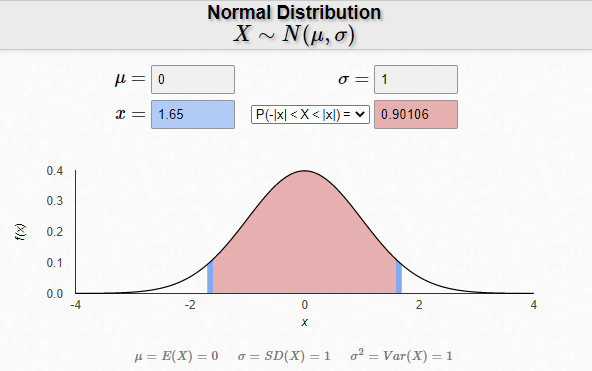

In [38]:
def calc_regression(x,y):
    res = stats.linregress(x.flatten(), y.flatten())
    a, b, r, p_value, std_err = res    
    return [a, b, r, p_value, std_err]


def extract_xy(df : pd.DataFrame, x_name : str , y_name : str, order_by : str,return_label=False):
    idx_notna = (df[x_name].notna()) &  (df[y_name].notna())
    ordered_notna = df[idx_notna].sort_values(by = order_by)
    x = ordered_notna[x_name]
    y = ordered_notna[y_name]
    if return_label:
        extract_xy.labels = ordered_notna[return_label]
    try:
        x = x.dt.days.to_numpy()
        y = y.dt.days.to_numpy()
    except:
        pass
    xy = np.zeros((2,x.shape[0]))
    xy[0] = x
    xy[1] = y
    return xy
    

def plot_graph(step): #plot_graph
    if step =="init":
        plot_graph.fig, plot_graph.axes = plt.subplots(num_subplots,1,figsize=(10,num_subplots*7))
    if step == "plot":
        ax = pg.axes[count]
        labels = extract_xy.labels.to_list()
        x_plot = np.linspace(x1.min()-10,x1.max()+10,100)
        [ax.annotate(labels[n],(x1[n],y1[n]),fontsize=1) for n in range(len(y1))] if SigTipoGeracao=="UHE" else 0
        ax.scatter(x2,y2,color="red",alpha=0.15,label="Outliers")
        ax.scatter(x3,y3,color="blue",alpha=0.15,label="Dados utilizados")
        ax.plot(x_plot,a*x_plot+b+1,color="green",label= f"RL: {a:.1f}x+{b:.1f}")
        ax.set_title(f"""\nTipo de geração: {SigTipoGeracao} Número total de usinas: {x1.shape[0]} - Usinas eliminadas: {x2.shape[0]} -\n\nCorrelação: = {r_str}  - Tempo até OC max: {th:.2f} meses""")
        ax.grid()
        #ax.plot(x_plot,x_plot-m,linewidth=2)
        ax.fill_between(x_plot,x_plot-th-m,x_plot+th-m,color="blue",alpha=0.15,label="Área de não exclusão")
        ax.fill_between(x_plot,x_plot-th-m,y1.min(),color="red",alpha=0.15,label="Área de exclusão")
        ax.fill_between(x_plot,x_plot+th-m,y1.max(),color="red",alpha=0.15)
        ax.set_xlim(x1.min(),x1.max())
        ax.set_ylim(y1.min(),y1.max())
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_xlabel(f"{nome_coluna} (meses)")
        ax.set_ylabel(f"Atraso (meses)")
    if step == "save":
        plt.tight_layout()
        plt.savefig(f"correlacao_marcos_{comercializacaoo}.pdf")
        plt.show()
        plt.close()
        
def coeff_matrix():
    dic = {}
    for comercializacao, inner_dict_1 in coeffs.items():
        for SigTipoGeracao, inner_dict_2 in inner_dict_1.items():
            for atraso,inner_dict_3 in inner_dict_2.items():
                for coeff, value in inner_dict_3.items():
                    try:
                        dic[(comercializacao,coeff)][(SigTipoGeracao,atraso)] = value
                    except:
                        dic[(comercializacao,coeff)] = {}
                        dic[(comercializacao,coeff)][(SigTipoGeracao,atraso)] = value
    return dic

def calc_regression(x,y):
    res = stats.linregress(x.flatten(), y.flatten())
    a, b, r, p_value, std_err = res    
    return [a, b, r, p_value, std_err]


def extract_xy(df : pd.DataFrame, x_name : str , y_name : str, order_by : str,return_label=False):
    idx_notna = (df[x_name].notna()) &  (df[y_name].notna())
    ordered_notna = df[idx_notna].sort_values(by = order_by)
    x = ordered_notna[x_name]
    y = ordered_notna[y_name]
    if return_label:
        extract_xy.labels = ordered_notna[return_label]
    try:
        x = x.dt.days.to_numpy()
        y = y.dt.days.to_numpy()
    except:
        pass
    xy = np.zeros((2,x.shape[0]))
    xy[0] = x
    xy[1] = y
    return xy

def coeff_matrix():
    dic = {}
    for comercializacao, inner_dict_1 in coeffs.items():
        for SigTipoGeracao, inner_dict_2 in inner_dict_1.items():
            for atraso,inner_dict_3 in inner_dict_2.items():
                for coeff, value in inner_dict_3.items():
                    try:
                        dic[(comercializacao,coeff)][(SigTipoGeracao,atraso)] = value
                    except:
                        dic[(comercializacao,coeff)] = {}
                        dic[(comercializacao,coeff)][(SigTipoGeracao,atraso)] = value
    return pd.DataFrame(dic)


def plot_graph(step): 
    #return 0 #descomentar para plotar
    if step =="init":
        plot_graph.fig, plot_graph.axes = plt.subplots(num_subplots,1,figsize=(10,num_subplots*7))
    if step == "plot":
        ax = plot_graph.axes[count]
        labels = extract_xy.labels.to_list()
        x_plot = np.linspace(x1.min()-10,x1.max()+10,100)
        [ax.annotate(labels[n],(x1[n],y1[n]),fontsize=1) for n in range(len(y1))] if SigTipoGeracao=="UHE" else 0
        ax.scatter(x2,y2,color="red",alpha=0.15,label="Outliers")
        ax.scatter(x3,y3,color="blue",alpha=0.15,label="Dados utilizados")
        ax.plot(x_plot,a*x_plot+b+1,color="green",label= f"RL: {a:.1f}x+{b:.1f}")
        ax.set_title(f"""\nTipo de geração: {SigTipoGeracao} Número total de usinas: {x1.shape[0]} - Usinas eliminadas: {x2.shape[0]} -\n\nCorrelação: = {r_str}  - Tempo até OC max: {th:.2f} meses""")
        ax.grid()
        #ax.plot(x_plot,x_plot-m,linewidth=2)
        ax.fill_between(x_plot,x_plot-th-m,x_plot+th-m,color="blue",alpha=0.15,label="Área de não exclusão")
        ax.fill_between(x_plot,x_plot-th-m,y1.min(),color="red",alpha=0.15,label="Área de exclusão")
        ax.fill_between(x_plot,x_plot+th-m,y1.max(),color="red",alpha=0.15)
        ax.set_xlim(x1.min(),x1.max())
        ax.set_ylim(y1.min(),y1.max())
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_xlabel(f"{nome_coluna} (meses)")
        ax.set_ylabel(f"Atraso (meses)")
    if step == "save":
        plt.tight_layout()
        plt.savefig(f"correlacao_marcos_{comercializacao}.pdf")
        plt.show()
        plt.close()
        

ACR
Não foi possível calcular: CC_OC para UTE: Inputs must not be empty.
Não foi possível calcular: CC_OC para UFV: Inputs must not be empty.


,DatInicioObraRealizado_atraso,DatConcretagemRealizado_atraso,DatMontagemRealizado_atraso,DatLiberacaoSFGTeste_atraso
UHE,91.2%,92.4%,21.6%,99.9%
UTE,92.5%,-,95.9%,99.9%
PCH,96.4%,97.6%,98.9%,99.9%
CGH,68.0%,93.9%,95.6%,99.9%
EOL,94.8%,95.1%,97.2%,99.9%
UFV,95.1%,-,95.3%,99.7%


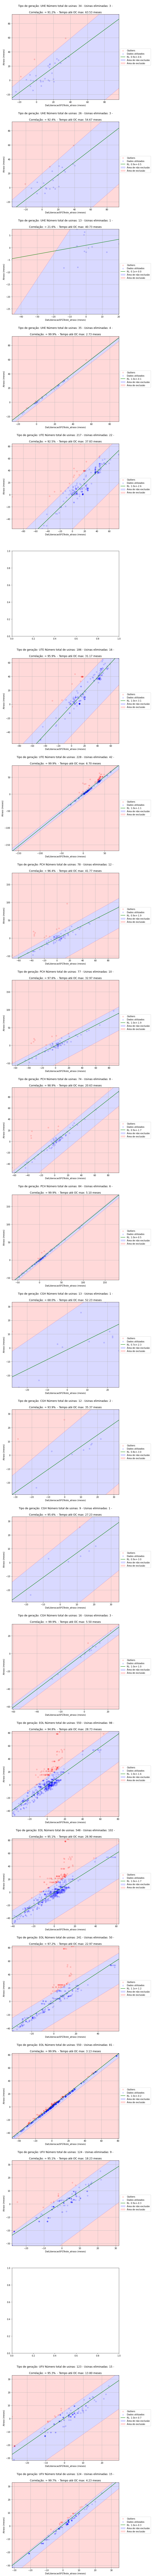

Fora do ACR


C:\Users\viniciusbarros\AppData\Local\Continuum\anaconda3\envs\aneel\lib\site-packages\scipy\stats\_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
C:\Users\viniciusbarros\AppData\Local\Continuum\anaconda3\envs\aneel\lib\site-packages\scipy\stats\_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\viniciusbarros\AppData\Local\Continuum\anaconda3\envs\aneel\lib\site-packages\scipy\stats\_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


Não foi possível calcular: CC_OC para UTE: Inputs must not be empty.
Não foi possível calcular: CC_OC para UFV: Inputs must not be empty.


,DatInicioObraRealizado_atraso,DatConcretagemRealizado_atraso,DatMontagemRealizado_atraso,DatLiberacaoSFGTeste_atraso
UHE,0.0%,0.0%,0.0%,100.0%
UTE,92.9%,-,93.7%,99.8%
PCH,97.3%,98.1%,98.9%,100.0%
CGH,68.1%,92.4%,95.1%,99.8%
EOL,64.3%,70.3%,88.6%,99.7%
UFV,92.3%,-,90.3%,99.0%


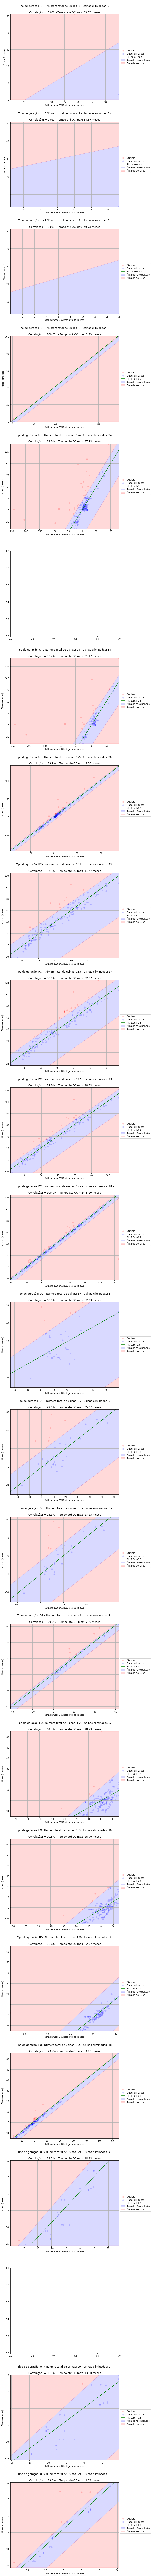

ACR           Fora do ACR          
                  a         b           a         b
UHE IO_OC  0.884466 -0.645467         NaN       NaN
    CC_OC  0.877030 -0.485034         NaN       NaN
    ME_OC  0.120430 -0.041846         NaN       NaN
    OT_OC  0.995159 -0.143144    1.014839 -0.225835
UTE IO_OC  0.983057 -2.604298    0.991516 -1.329433
    ME_OC  1.019189 -3.130767    1.057989 -2.450777
    OT_OC  1.026837 -1.123707    1.008705 -0.622286
PCH IO_OC  0.901681 -1.918159    1.034602 -2.713490
    CC_OC  0.960748 -1.883686    0.997998 -1.750036
    ME_OC  0.944054 -1.711382    1.008386 -0.436171
    OT_OC  0.999826 -0.530715    0.995637 -0.211297
CGH IO_OC  0.720305 -2.344350    0.814833  1.907017
    CC_OC  0.831829 -3.037371    1.042379 -1.814302
    ME_OC  0.896275 -2.964376    1.041629 -1.751466
    OT_OC  1.015766 -1.039878    1.017706 -0.493874
EOL IO_OC  0.978787 -1.595049    0.654354 -1.476371
    CC_OC  1.004386 -1.700567    0.740940 -2.646118
    ME_OC  1.071556 -1.178996    0.883170 -3.668688
    OT_OC  1.003037 -0.155329    0.996478 -0.101681
UFV IO_OC  0.879728 -0.312676    0.922837 -0.430391
    ME_OC  0.982004 -0.670440    0.819016 -0.784547
    OT_OC  0.981642 -0.343965    1.001883 -0.146615

In [39]:
th_nornm = 2
   
num_subplots = (len(tipos_geracao))*(len(nomes_colunas_atrasos))
coeffs = {"ACR":{},"Fora do ACR":{}}


for comercializacao in ["ACR","Fora do ACR"]:
    print(comercializacao)
    plot_graph(step="init")
    matrix_pearson = {}
    count = -1
    for i,SigTipoGeracao in enumerate(tipos_geracao):
        matrix_pearson[SigTipoGeracao] = []
        coeffs[comercializacao][SigTipoGeracao] = {}
        for fase, marco in dict_fase_marco.items():      #fase in nomes_colunas_atrasos:
            coeffs[comercializacao][SigTipoGeracao][fase] = {}
            count+=1            
            try:
                # Máscara com apenas indices que correspondem ao tipo geração especificado
                mask_geracao = (atraso_usina.SigTipoGeracao == SigTipoGeracao ) & (atraso_usina.DscComercializacaoEnergia==comercializacao)
                # Todos pares x,y para o tipo geracao tal que: x = Atraso y = Atraso do marco especificado
                x1,y1 =  extract_xy(atraso_usina[mask_geracao], f"{marco}_atraso", "Atraso", f"{marco}_atraso",return_label="IdeUsinaOutorga")/30
                m = dict_tempo_fase_mean_std[SigTipoGeracao][f"{fase}_media"]
                std = dict_tempo_fase_mean_std[SigTipoGeracao][f"{fase}_std"]
                th = (th_norm*std)+m
                outliers = ((tempo_construcao_por_usina[fase]) > th)| ((tempo_construcao_por_usina[fase]) < -th)
                x2,y2 = extract_xy(atraso_usina[mask_geracao & outliers], f"{marco}_atraso", "Atraso", f"{marco}_atraso")/30
                x3,y3 = extract_xy(atraso_usina[mask_geracao & ~outliers], f"{marco}_atraso", "Atraso", f"{marco}_atraso")/30
                a, b, r, p_value, std_err = calc_regression(x3,y3)
                coeffs[comercializacao][SigTipoGeracao][fase]["a"] = a
                coeffs[comercializacao][SigTipoGeracao][fase]["b"] = b
                r_str = f"{100*r:.1f}%"
                # Converte para meses
                th = th.days/30
                m = m.days/30
                std = std.days/30
                plot_graph(step="plot")
                calc.loc[mask_geracao, f"{marco}_atraso_a"] = a
                calc.loc[mask_geracao, f"{marco}_atraso_b"] = b
                tempo_fase_prev = (calc[f"{marco}_atraso"] * calc.loc[mask_geracao, f"{marco}_atraso_a"] )+ (calc.loc[mask_geracao, f"{marco}_atraso_b"]*pd.to_timedelta(1,'D'))
                calc.loc[mask_geracao,f"{marco}_Prev_OC"] = calc[marco] + tempo_fase_prev
                matrix_pearson[SigTipoGeracao].append(r_str)
            except (ValueError,AttributeError) as error:
                print(rf"Não foi possível calcular: {fase} para {SigTipoGeracao}: {error}")
                matrix_pearson[SigTipoGeracao].append("-")
    matrix_pearson =  pd.DataFrame(matrix_pearson,nomes_colunas_atrasos)
    display(matrix_pearson.T)
    plot_graph(step="save")

matrix_pearson =  pd.DataFrame(matrix_pearson,nomes_colunas_atrasos)
coeffs =  coeff_matrix()
display(coeffs)

In [18]:
x3

array([14.9])

In [19]:
comercializacao

'Fora do ACR'

In [20]:
fase

'IO_OC'

In [ ]:
calc[['IdeUsinaOutorga', 'SigTipoGeracao', 'origem',
       'DscComercializacaoEnergia',"DatLiberacaoSFGTeste_Prev_OC","DatLiberOpComerRealizado"]].sample(20)

In [ ]:
calc.to_excel("calc.xlsx")